<a href="https://colab.research.google.com/github/gianlucaleone/Hardware-oriented-spike-detection/blob/main/Spike_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spike Detection Pipeline – Simulation & Hardware-Oriented Implementation**

This notebook implements a complete spike-detection pipeline for simulated extracellular recordings.  
It is designed both for algorithm exploration and for preparing hardware-compatible test vectors.

---

## **Overview**

1. **Dataset loading**  
   Import of the Quiroga simulated dataset and extraction of ground-truth spikes.

2. **(Optional) Synthetic LFP generation**  
   Addition of low-frequency LFP components to improve the quality of the testing intracortical signals.

3. **Quantization (8-bit)**  
   Signal normalization and conversion to int8 to match ADC behavior.

4. **Filtering**  
   High-pass filtering using hardware-friendly methods:  
   **DIFF**, **MAD**, or **FIR**.

5. **Spike emphasis**  
   Enhancement using **ABS**, **NEO**, or **ASO** to make spikes easier to detect.

6. **Thresholding & detection**  
   Window-based threshold computation and spike extraction.

7. **Refractory period**
   Ignore detections for a few samples after each spike.

8. **Accuracy evaluation**  
   TP/FP/FN computation within a certain tolerance window.

9. **Hardware test export**  
   Generation of text files containing input/output/internal signals for FPGA/ASIC tests.

---

Use this notebook as a compact reference for developing real-time spike detection algorithms and validating hardware implementations.


# Dataset

The original paper *“Unsupervised spike detection and sorting with wavelets and
superparamagnetic clustering”* (Quian Quiroga et al., 2004) referenced the
dataset as being available on **www.vis.caltech.edu/~rodri/**.  
That website is no longer online, but the dataset is still publicly available,
for example here:  
https://figshare.le.ac.uk/articles/dataset/Simulated_dataset/11897595

In [222]:
#@title Dataset loading
from scipy.io import loadmat

# The dataset contains multiple simulated neural recordings along with their
# ground-truth spike times and spike classes.
#
# You can import any of the dataset tracks: simply drag and drop the one you
# want in the left panel and make sure to use the corresponding filename
# when calling loadmat().

dataset = loadmat("C_Difficult2_noise015")
raw = dataset["data"][0]
gt_time = dataset["spike_times"][0][0][0]
gt_id   = dataset["spike_class"][0][0][0]
neurons    = gt_id.max() + 1

import numpy as np

# Use case characteristics
fs = 24000       # Hz
T  = 0.025       # s
t = np.arange(0, T, 1/fs) # time vector
n = len(t) # number of samples
threshold_window = 0.01 # sec

# Keep only the spike indexes of the considered portion of signal
raw_signal = raw[:n] # reduce signal length
# remove spikes above the considered signal length
last_spike = np.where(gt_time/fs>t[-1])[0][0]
# The ground truth contains the start time of the spikes
# the peaks are about 19-16 samples later
gt_time = gt_time[0:last_spike]  + 24
gt_id   = gt_id[0:last_spike]

# Dataset manipulation
Simple manual synthetic Local Field Potential insertion and sample quantization to match ADC bit resolution

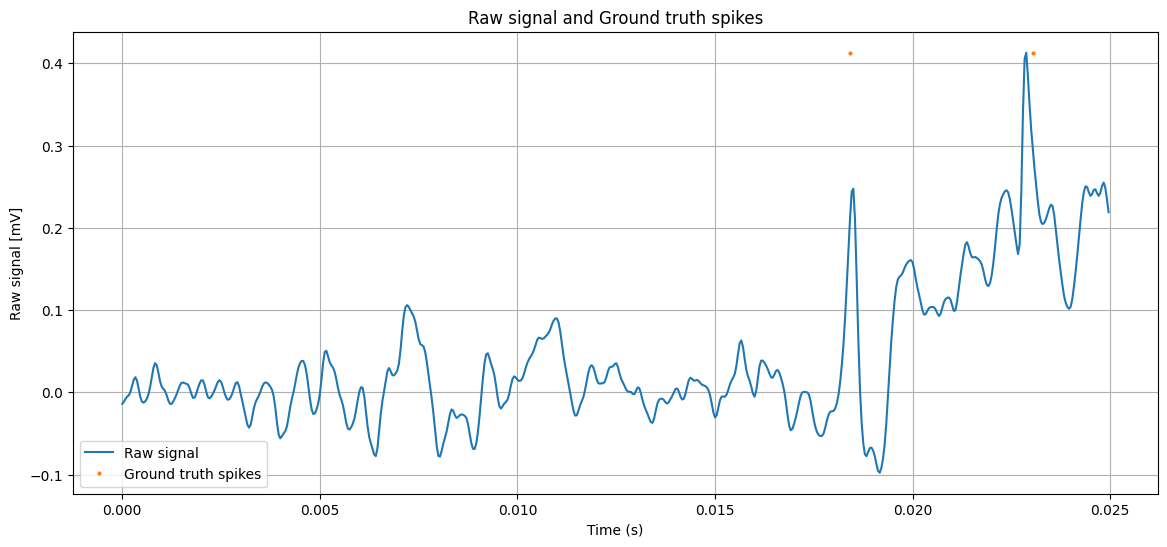

In [223]:
#@title Manual synthetic Local Field Potential (LFP) insertion
# The synthetic dataset used in this notebook does not include a strong local
# field potential (LFP) component, which is typically present in intracortical
# recordings. The LFP reflects the summed synaptic activity of neuron
# populations located farther from the electrode. Because spikes generated by
# distant neurons propagate through the extracellular medium, which acts as a
# low-pass filter, the resulting LFP mainly contains low-frequency components
# (approximately 0–400 Hz).

# Synthetic local field potential kernel creation
# We create a stereotyped LFP kernel for each neuron. The idea is that whenever
# a neuron close to the electrode spikes, it is accompanied by the activity of
# a distant population of neurons, producing a low-frequency LFP contribution.

def make_ulfp_kernel(fs, tau=0.01, dur=0.1):
    kt = np.arange(0, dur, 1/fs)
    # alpha-function-like kernel
    k = kt * np.exp(-kt / tau)
    # normalize
    k /= np.max(np.abs(k))
    return k

# Synthetic LFP signal composition
# For each neuron, an LFP signal is generated by convolving its spike times
# with its corresponding LFP kernel. The final LFP is obtained by summing all
# these individual contributions.

def spikes_to_lfp(spike_time, fs, T, kernel):
    t = np.arange(0, T, 1/fs)
    lfp = np.zeros_like(t)

    klen = len(kernel)

    for spike in spike_time:
        if(spike+klen < len(lfp)):
          lfp[spike:spike+klen] += kernel
        else:
          if(spike<len(lfp)):
            lfp[spike:] += kernel[:len(lfp)-spike]

    return lfp

# LFP kernel set for all neurons
ulfps = [
    (-1)**k*make_ulfp_kernel(fs, tau=0.005*k, dur=0.6)
    for k in range(1,neurons+1)
]

# Build LFP for each neuron using ground-truth spike times
lfps = [
    spikes_to_lfp(gt_time[gt_id == k], fs, T, 0.25*ulfps[k-1])
    for k in range(neurons)
]

# Dataset and LFP combination
# The synthetic LFP signal is added to the original dataset to produce a more
# realistic intracortical recording, where both spikes and low-frequency
# components are present.

lfp = np.sum(lfps, axis=0)
raw_signal = lfp[0:n]+ 0.25*raw[0:n]
timesteps = t

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(t,raw_signal,label='Raw signal')
plt.title("Raw signal and Ground truth spikes")
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Raw signal [mV]")
peak = np.max(raw_signal)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')
plt.legend(loc='lower left')

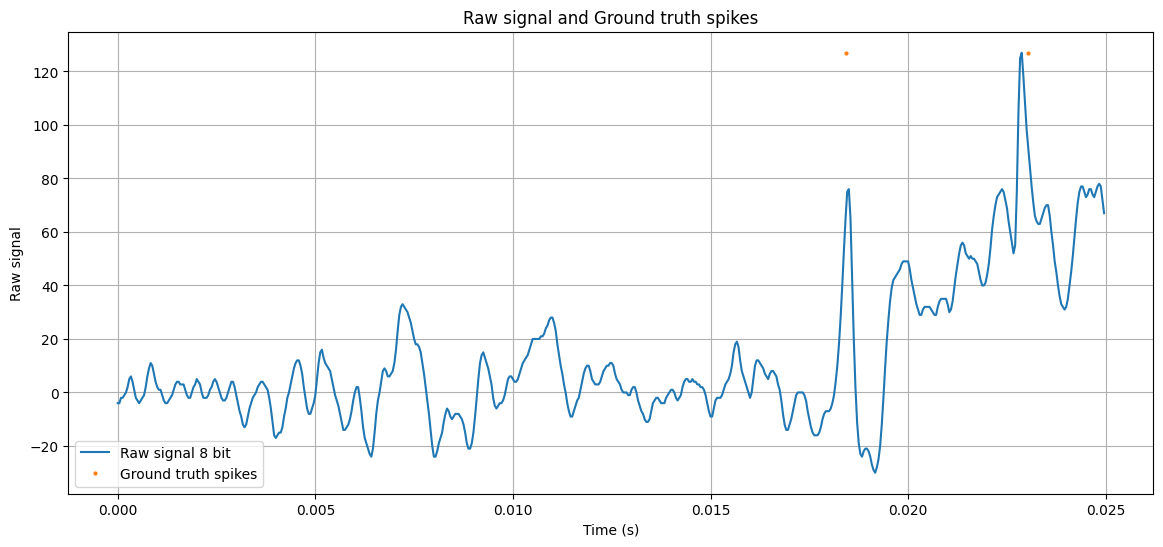

In [224]:
#@title Quantization to 8 bits
# Since the target ADC has an 8-bit resolution, we apply the same quantization
# here to obtain a Python-based integer model that matches the behavior of the
# digital hardware.
#
# The signal is first normalized, then scaled to the 8-bit signed range
# (−127 to +127), rounded, and finally cast to int8.

peak = np.max(np.abs(raw_signal))
raw_signal = raw_signal/peak
raw_signal = np.int8(np.round(raw_signal*127))

plt.figure(figsize=(14, 6))
plt.plot(t,raw_signal,label='Raw signal 8 bit')
plt.title("Raw signal and Ground truth spikes")
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Raw signal")
peak = np.max(raw_signal)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')
plt.legend(loc='lower left')

# Filtering

/tmp/ipython-input-452308995.py:35: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20*np.log10(np.abs(h)))


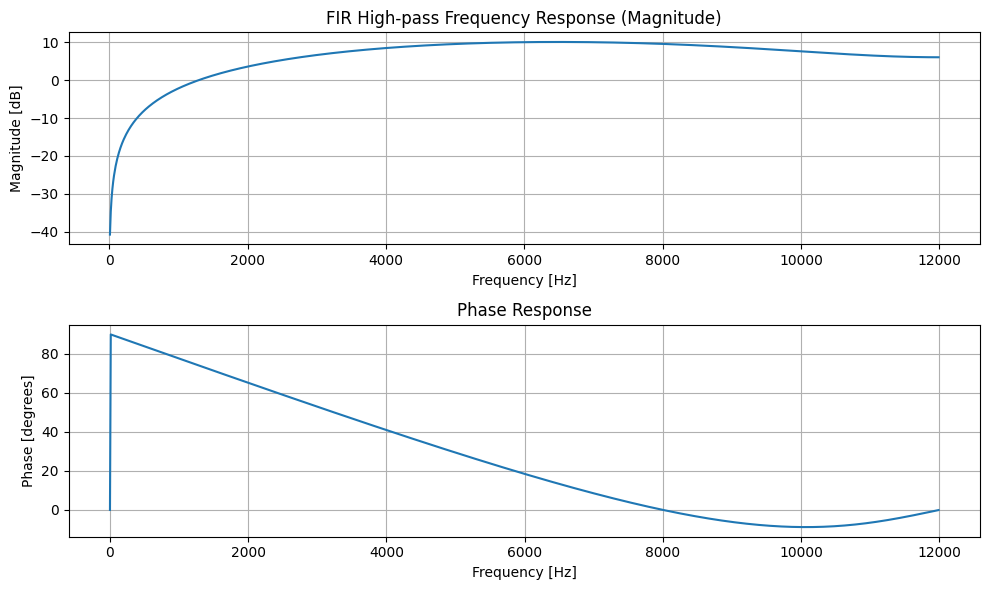

In [225]:
#@title Filter design
# Spikes are typically in the 400–10,000 Hz band.
# High-pass or band-pass filters are typically used to separate spikes from LFPs
# and low-frequency noise.

import numpy as np
from scipy.signal import firwin, freqz

# You can choose between three filters:
# - Finite Impulse Response: a standard, always-stable FIR high-pass filter.
# - Moving Average Difference: removes low-frequency components by subtracting
#                              from the current sample the mean of moving window,
#                              computed using a mean average filter.
# - Difference filter: removes low-frequency components by subtracting adjacent
#                      samples

filter_type = "MAD"

if filter_type == "MAD":
        b = [2, -1, -1]
elif filter_type == "DIFF":
        b = [1, -1]
elif filter_type == "FIR":
        taps = 101
        cutoff = 400
        b = firwin(taps, cutoff, pass_zero=False, fs=fs)
else:
        raise ValueError("Unknown filter type")

w, h = freqz(b, worN=1024, fs=fs)

# Magnitudine plot (dB)
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(w, 20*np.log10(np.abs(h)))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("FIR High-pass Frequency Response (Magnitude)")
plt.grid(True)

# Phase plot (radians)
plt.subplot(2,1,2)
plt.plot(w, np.degrees(np.angle(h)))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [degrees]")
plt.title("Phase Response")
plt.grid(True)

plt.tight_layout()
plt.show()

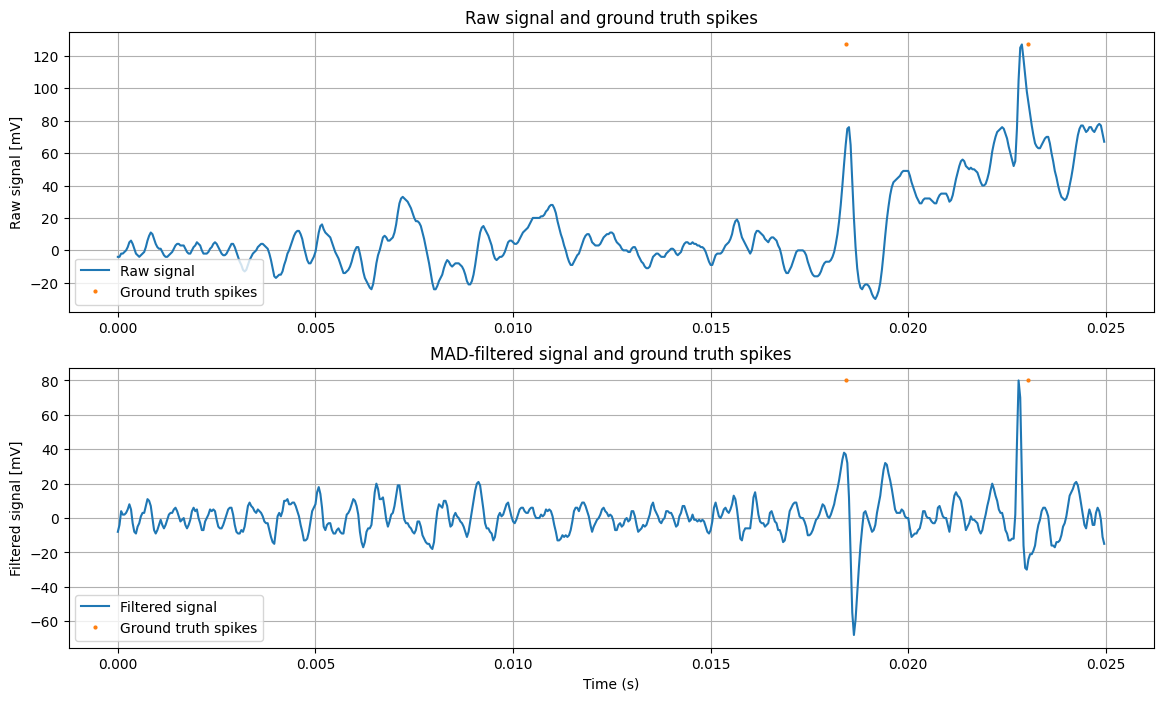

In [226]:
#@title Filtering stage

filtered = np.convolve(raw_signal, b, mode="full")
filtered = filtered[0:-len(b)+1]

plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
plt.plot(timesteps,raw_signal,label='Raw signal')
peak = np.max(raw_signal)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')
plt.title(f'Raw signal and ground truth spikes')
plt.ylabel("Raw signal [mV]")
plt.legend(loc='lower left')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(timesteps, filtered, label='Filtered signal')
plt.title(f'{filter_type}-filtered signal and ground truth spikes')
peak = np.max(filtered)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')
plt.xlabel("Time (s)")
plt.ylabel("Filtered signal [mV]")
peak = np.max(raw_signal)
plt.legend(loc='lower left')
plt.grid(True)

# Spike waveform emphasis

In [227]:
#@title Spike emphasis TO CHECK

# Spike emphasis aims at simplifying the spike detection step.
# These algorithms take advantage of the narrow shape of spikes to enhance
# their amplitude while suppressing the rest of the signal.
#
# You can choose between three spike emphasis methods:
#
# - ABS / none:
#     If the noise level is low, simply taking the absolute value of the signal
#     may be sufficient to detect both positive and negative spike deflections.
#
# - Non-Linear Energy Operator (NEO): NEO(t) = x(t-1)^2 − x(t) * x(t-2)
#
#     If x(t−1) corresponds to the spike peak, it tends to be larger than its
#     adjacent samples x(t) and x(t−2). The NEO exploits this property and
#     produces a processed signal that accentuates spike peaks. If x(t−1) is not
#     a peak, the value x(t−1)^2 and the product x(t)*x(t−2) are similar, and
#     their difference approaches zero.
#
# - Amplitude Slope Operator (ASO): ASO(t) = x(t) * [x(t) − x(t−1)]
#
#     If x(t) is a spike peak, both the amplitude x(t) and its local derivative
#     (x(t) − x(t−1)) are larger than usual. Like the NEO, the ASO processed
#     spike peaks while suppressing the rest of the signal.

x = filtered;
emphasis_type = "ABS"

if emphasis_type == "NEO":
  #NEO(t) = x(t-1)^2 - x(t)*x(t-2)
  NEO = x[1:-1]**2 - x[2:]*x[:-2]
  NEO = np.concatenate(([0,x[0]*x[0]], NEO));
  emph = NEO;
elif emphasis_type == "ASO":
  #abs(ASO(t)) = abs(x(t)*[x(t)*x(t-1)])
  ASO = x[1:-1]*(x[1:-1]*x[:-2])
  ASO = np.concatenate(([0,x[0]*x[0]], ASO));
  ASO = np.abs(ASO);
  emph = ASO;
elif emphasis_type == "ABS":
  #ABS(t) = abs(x(t))
  ABS = np.abs(x)
  emph = ABS;
else:
  raise ValueError("Unknown emphasis type")

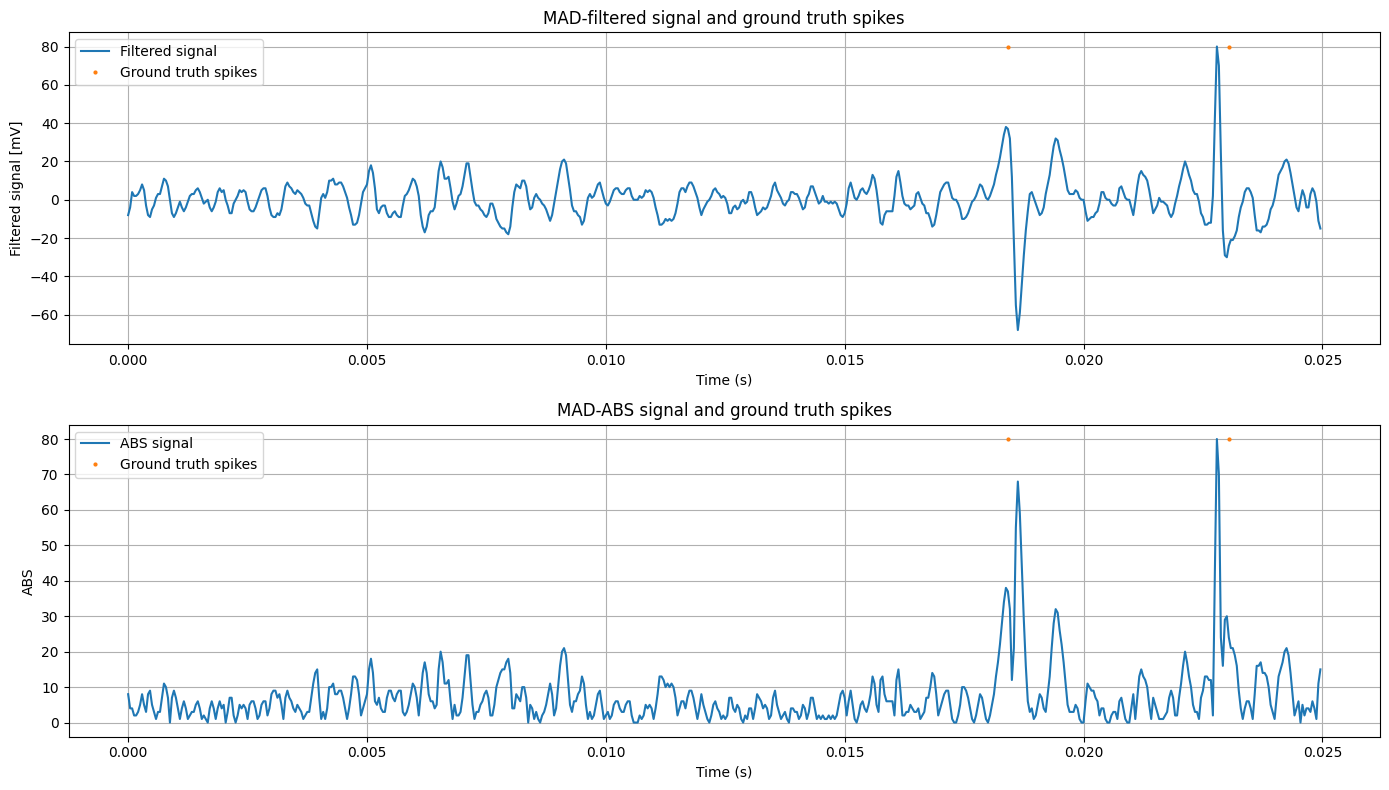

In [228]:
#@title Emphasis plot

plt.figure(figsize=(14, 8))

plt.subplot(2,1,1)

plt.plot(timesteps, filtered, label='Filtered signal')

peak = np.max(filtered)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')

plt.xlabel("Time (s)")
plt.ylabel("Filtered signal [mV]")
plt.legend()
plt.title(f'{filter_type}-filtered signal and ground truth spikes')
plt.grid(True)

plt.subplot(2,1,2)

plt.plot(timesteps, emph, label=f'{emphasis_type} signal')

peak = np.max(emph)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')

plt.xlabel("Time (s)")
plt.ylabel(f"{emphasis_type}")
plt.title(f'{filter_type}-{emphasis_type} signal and ground truth spikes')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Threshold computation

In [229]:
#@title Spike threshold

# Spikes are detected by selecting a threshold above which a sample is
# considered to be a spike. The threshold is computed using a metric that
# captures the typical amplitude of the neural signal and is exceeded only
# when unusually large values occur, such as during spikes. This metric is
# usually scaled by multiplying it by a constant factor.
#
# Several thresholding strategies can be used. In this implementation you can
# choose between:
#
# - Mean: the mean value of the processed signal.
#
# - Root Mean Square (RMS): the root mean square of the processed signal.
#   When RMS is selected, the square of the processed signal is used to
#   avoid computing the square root. The threshold condition:
#         x(t) > sqrt(sum(x^2))
#   becomes:
#         x^2(t) > sum(x^2)
#
#
# The threshold is usually re-computed over time, in this case about every second.
# The rationale behind this is that if you compute the threshold at a random
# moment at the beginning of the acquisition, you have no guarantee that this
# value will remain valid. For example, if you pick a moment where many spikes
# occur, the estimated threshold will be too high and you will miss several
# spikes later on.

threshold_type = "MEAN"

thr_w            = threshold_window*fs # sample
# to avoid a division later we can select a window size which is a power of two,
# the closest to 1 sec
thr_w = np.int64(2**np.round(np.log2(thr_w)))
threshold_window = thr_w/fs
print(f'Threshold window: {threshold_window} sec')

window_number = int(np.ceil(emph.shape[0]/thr_w));

thresholds = np.array([],dtype=np.int64)

if threshold_type == "MEAN":
  for i in range(window_number):
    accumulation = np.sum(emph[int(i*thr_w):int((i+1)*thr_w)])

    # Multiplication by a corrective constant. These values can be manually tuned.

    accumulation *= 4*(emphasis_type == "ABS") + 20*(emphasis_type == "NEO") + 30*(emphasis_type == "ASO");

    # In the hardware implementation, division is performed using a right shift,
    # so values must be truncated to match the hardware behavior.

    thr = np.int64(accumulation/thr_w)
    thresholds = np.append(thresholds, thr)

    detector_in = emph

elif threshold_type == "RMS":
  for i in range(window_number):
    square_accumulation = np.sum(emph[int(i*thr_w):int((i+1)*thr_w)]**2)

    # Multiplication by a corrective constant. These values can be manually tuned.
    square_accumulation *= 10*(emphasis_type == "ABS") + 30*(emphasis_type == "NEO") + 30*(emphasis_type == "ASO");

    # In the hardware implementation, division is performed using a right shift,
    # so values must be truncated to match the hardware behavior.

    thr = np.int64(square_accumulation/thr_w)
    thresholds = np.append(thresholds, thr)

  # To avoid square root computation
  detector_in = emph**2;
else:
  raise ValueError("Unknown threshold type")

# In the first calibration window, no threshold has been computed yet, so spike
# detection cannot be performed there. This initial segment is used exclusively
# to estimate the threshold for the subsequent windows. For this reason,
# ground-truth spikes falling inside the first calibration window must be
# removed from the evaluation, since detection is not possible in that interval.

first_window_last_gt_spike = np.where(timesteps[gt_time]>timesteps[thr_w])[0][0]
gt_time = gt_time[first_window_last_gt_spike:]
gt_id    = gt_id[first_window_last_gt_spike:]

print(thresholds)

Threshold window: 0.010666666666666666 sec
[25 28 15]


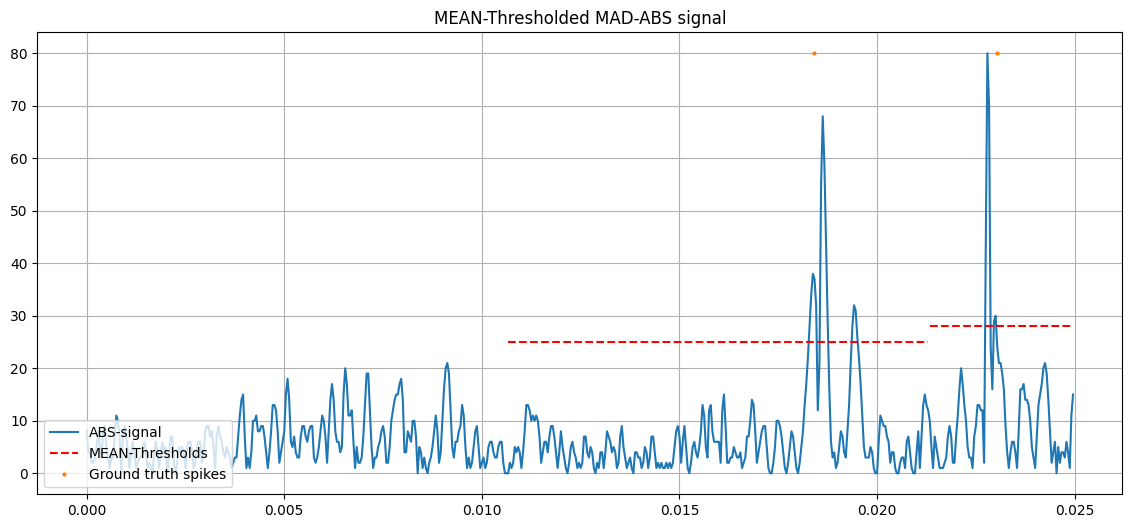

In [230]:
#@title Thresholded signal plot
plt.figure(figsize=(14, 6))
plt.plot(timesteps, detector_in,label=f'{emphasis_type}-signal')
plt.title(f"{threshold_type}-Thresholded {filter_type}-{emphasis_type} signal")
plt.grid(True)
for i in range(1,window_number):
    x_segment = timesteps[int(i*thr_w):int((i+1)*thr_w)]
    y_segment = np.full_like(x_segment, thresholds[i-1])
    plt.plot(x_segment,y_segment, linestyle='--',color = 'red',label=f"{threshold_type}-Thresholds" if i == 1 else None)
peak = np.max(detector_in)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')
plt.legend(loc='lower left')

# Threshold crossing

In [231]:
#@title Spike detection
# For each window (and for each threshold value),
# spike detection is performed by checking which samples
# exceed the threshold using np.where().

detected_spikes = []
for i in range(1,window_number):
  thr = thresholds[i-1];
  window = detector_in[int(i*thr_w):int((i+1)*thr_w)];
  spike_indices = np.where(window > thr)[0]

  # The + int(i * thr_w) term shifts the spike indices from window-relative
  # coordinates (0 ... window_size) to global signal coordinates. Each window
  # starts at sample i * thr_w in the full signal, so this offset must be added
  # to correctly place the detections in the full timeline.

  spike_indices += int(i*thr_w);
  detected_spikes.append(spike_indices)
spike_time = np.concatenate(detected_spikes)

Text(0.5, 1.0, 'Threshold crossing - Window 1')

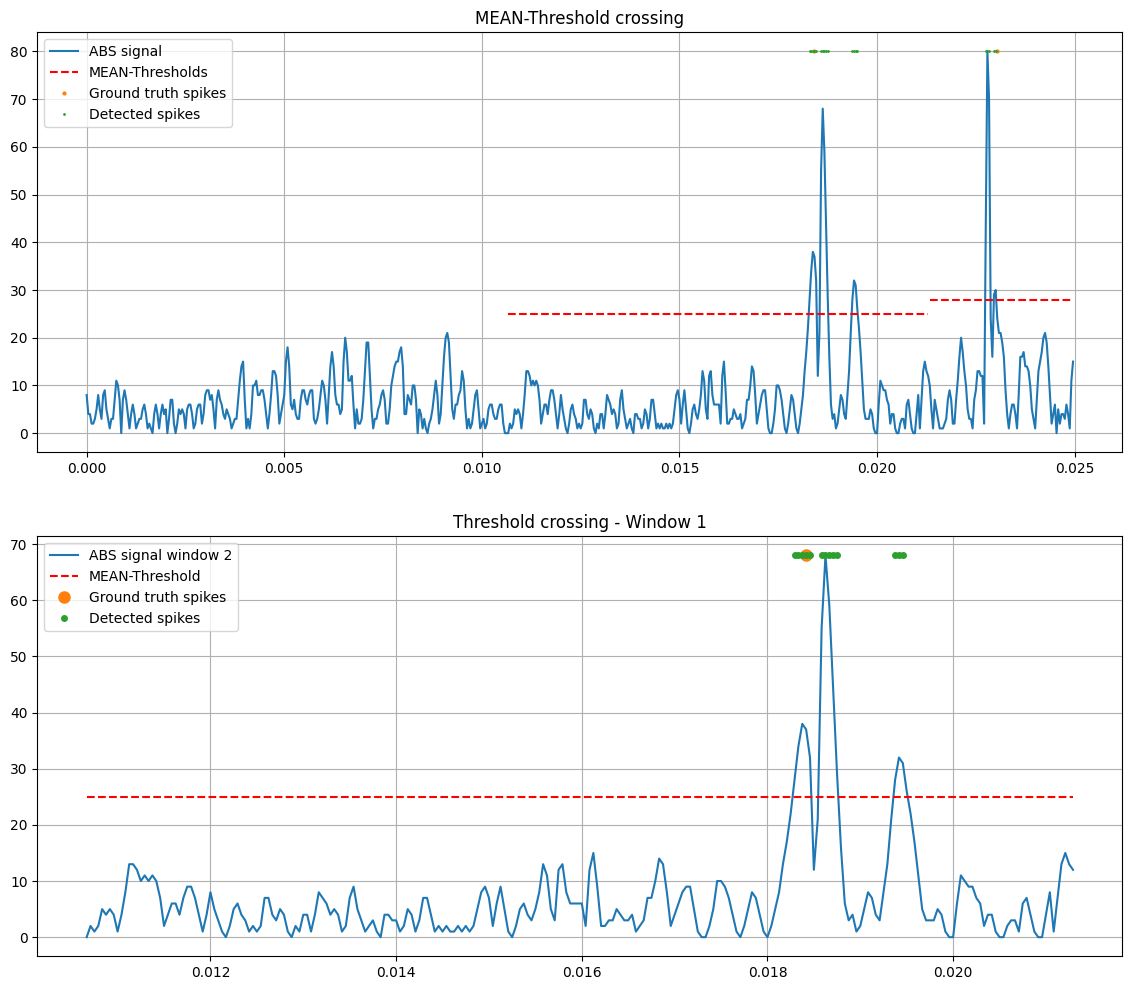

In [232]:
#@title Detected spikes plot

plt.figure(figsize=(14, 12))

# The figure contains two plots:
# 1) The full recording, showing the processed signal, thresholds for each
#    window, and all ground-truth and detected spikes.
# 2) A zoomed-in view of a single window selected via 'win2show', allowing for
#    detailed inspection of threshold crossings and local spike detection
#    performance.

plt.subplot(2,1,1)

plt.plot(timesteps, detector_in,label=f'{emphasis_type} signal')
plt.title(f"{threshold_type}-Threshold crossing")
plt.grid(True)
for i in range(1,window_number):
    x_segment = timesteps[int(i*thr_w):int((i+1)*thr_w)]
    y_segment = np.full_like(x_segment, thresholds[i-1])
    plt.plot(x_segment,y_segment, linestyle='--',color = 'red',label=f"{threshold_type}-Thresholds" if i == 1 else None)
peak = np.max(detector_in)
plt.plot(timesteps[gt_time],peak*np.ones_like(gt_time),'o', markersize=2,label='Ground truth spikes')
plt.plot(timesteps[spike_time], peak*np.ones_like(spike_time), 'o', markersize=1, label='Detected spikes')
plt.legend(loc='upper left')

plt.subplot(2,1,2)

win2show = 1
win2showp1 = win2show + 1

x_segment = timesteps[int(win2show*thr_w):int(win2showp1*thr_w)]
y_segment = np.full_like(x_segment, thresholds[0])

plt.plot(x_segment, detector_in[win2show*thr_w:win2showp1*thr_w],label=f'{emphasis_type} signal window 2')
plt.grid(True)
plt.plot(x_segment,y_segment, linestyle='--',color = 'red',label=f"{threshold_type}-Threshold")
peak = np.max(detector_in[win2show*thr_w:win2showp1*thr_w])

last_gt = np.where(timesteps[gt_time]>timesteps[win2showp1*thr_w])[0][0]
first_gt = np.where(timesteps[gt_time]>timesteps[win2show*thr_w])[0][0]
gt_to_plot = gt_time[first_gt:last_gt]
plt.plot(timesteps[gt_to_plot], peak*np.ones_like(gt_to_plot), 'o', markersize=8, label='Ground truth spikes')

last_spike = np.where(timesteps[spike_time]>timesteps[win2showp1*thr_w])[0][0]-1
first_spike = np.where(timesteps[spike_time]>timesteps[win2show*thr_w])[0][0]
spike_to_plot = spike_time[first_spike:last_spike]
plt.plot(timesteps[spike_to_plot],peak*np.ones_like(spike_to_plot),'o', markersize=4,label='Detected spikes')
plt.legend(loc='upper left')
plt.title(f"Threshold crossing - Window {win2show}")

We detected 19 spikes,
while the ground truth contains 2 spikes :(


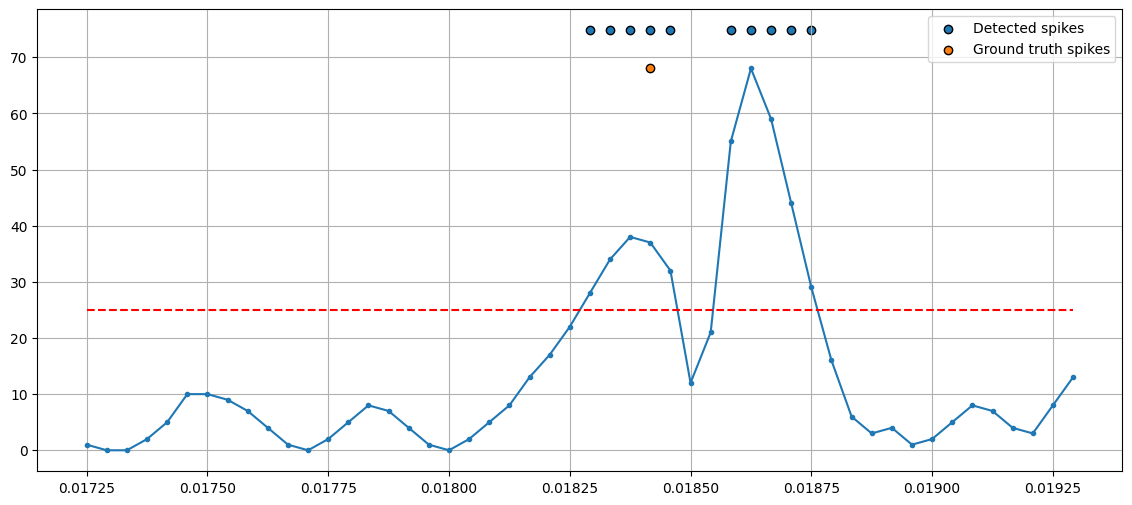

In [233]:
#@title Multiple detection :(
# Because of the duration of the spike waveform, a single spike is detected
# multiple times across consecutive samples.

print(f'We detected {len(spike_time)} spikes,')
print(f'while the ground truth contains {len(gt_time)} spikes :(')

start_spike = 0
t1 = spike_time[start_spike] - 25
t2 = t1 + 50
r1 = np.where(timesteps[gt_time]<timesteps[t2])[0];
r2 = np.where(timesteps[spike_time]<timesteps[t2])[0];

plt.figure(figsize=(14, 6))
plt.plot(timesteps[t1:t2], detector_in[t1:t2],marker='.')

plt.scatter(timesteps[spike_time[r2]], np.ones_like(r2) * peak + 0.1*peak, edgecolors='black',  label='Detected spikes')
plt.scatter(timesteps[gt_time[r1]],    np.ones_like(r1) * peak,     edgecolors='black', label='Ground truth spikes')

plt.plot(timesteps[t1:t2], thresholds[0]*np.ones_like(timesteps[t1:t2]), linestyle='--',color = 'red')
plt.legend()

plt.grid(True)

In [234]:
#@title Remove multiple detection
# We can remove multiple detections by discarding spikes that occur closer
# than a given minimum distance from each other.
# In hardware, the same effect can be achieved by disabling the detector
# module for a certain amount of samples after each detection

keep = [spike_time[0]]
last = spike_time[0]
distance = fs*0.0005 # 12 samples, 0.5 ms

print(f'detected spike: {len(spike_time)}')

for s in spike_time[1:]:
  if s - last >= distance:
    keep.append(s)
    last = s

spike_time = np.array(keep)

print(f'Kept spike: {len(spike_time)}')
print(f'The ground truth has {len(gt_time)} spikes')

detected spike: 19
Kept spike: 3
The ground truth has 2 spikes


# Accuracy

In [235]:
#@title Accuracy measurement
# In this section we evaluate the accuracy of the spike detector by comparing
# the detected spikes with the ground-truth spike times. Three metrics are
# computed:
#
# - True Positive (TP): a detected spike that matches a ground-truth spike
#   within a tolerance window of ±t samples.
#
# - False Positive (FP): a detected spike that does not correspond to any
#   ground-truth spike (i.e., a spurious detection).
#
# - False Negative (FN): a ground-truth spike for which no detection was made
#   within the tolerance window (i.e., a missed spike).
#
# By comparing detected spikes against the remaining ground-truth spikes, and
# removing matched spikes to avoid double counting, we compute TP, FP, and FN.
#
# Depending on the application, false positives (FP) or false negatives (FN)
# may have different levels of importance. In this context we consider them
# equally important, so the threshold scaling factor can be tuned to balance
# the number of FP and FN in the final detection results.


t = distance # tolerance in samples. 1 ms is the average spike waveform length
gt_time2 = np.copy(gt_time)
true_positive = 0

for s in spike_time:
  s1 = s-t;
  s2 = s+t;
  list1 = np.where(gt_time2 > s1)[0]
  list2 = np.where(gt_time2 < s2)[0]
  intersection = np.intersect1d(list1,list2)
  if(intersection.size != 0):
    gt_time2 = np.delete(gt_time2,intersection[0])
    true_positive += 1

false_negative = len(gt_time2)
false_positive = len(spike_time) - true_positive
true_spike = len(gt_time)

print(f"True positives: {100*true_positive/true_spike}")
print(f"False positives: {100*false_positive/true_spike}")
print(f"False negatives: {100*false_negative/true_spike}")

True positives: 100.0
False positives: 50.0
False negatives: 0.0


# Hardware Test

For hardware testing, it is possible to generate input, output, and internal variable files (b, filtered, emph).  
To make the tests more manageable, it is convenient to reduce the dataset duration from 10 seconds to 0.025 seconds and the threshold window to 0.01 seconds.


In [236]:
#@title Hardware files

import os
os.makedirs("hardware_files", exist_ok=True)

arrays = {
    "raw_signal": raw_signal,
    "b": b,
    "emph": emph,
    "thresholds": thresholds,
    "spike_time": spike_time
}

for name, arr in arrays.items():
    with open(f"hardware_files/{name}.txt", "w") as f:
        for v in arr:
            f.write(f"{v}\n")